# Model V1

In [37]:
best_config = {'lstm_bidirectional': False,
                'batch_size': 64,
                'lstm_hidden': 96,
                'lstm_layers': 2,
                'lstm_dropout': 0.1,
                'gat_hidden': 96,
                'gat_dropout': 0.1,
                'gat_alpha': 0.1,
                'final_dropout': 0.2,
                'learning_rate': 0.0007023432254879037,
                'lstm_weight_decay': 0.0005708066170581489,
                'gat_weight_decay': 1.6797946539308408e-05,
                'final_weight_decay': 0.00017357100923169329}

In [38]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Load Data and Split Training and Testing

In [39]:
import os
import pandas as pd
import numpy as np

tickers = ['AAPL', 'AMZN', 'BA', 'COST', 'JNJ', 'NVDA', 'TMO', 'TSLA', 'VLO']
data_dir = "Data"
features = ['close', 'volume', 'log_return']

all_data = {}
min_length = float('inf')

for stock in tickers:
    df = pd.read_csv(os.path.join(data_dir, f"{stock}_with_sentiment_features_with_product.csv"))
    
    # If log_return is not already present, add it
    if 'log_return' not in df.columns:
        df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    
    # Fill missing price features using forward fill (safer for price data)
    price_feats = ['open', 'high', 'low', 'close', 'volume',
                   'ann_return_1w', 'ann_return_2w', 'ann_return_1m',
                   'rolling_vol_7d', 'ann_volatility', 'macd_1w_1m', 'log_return']
    for feat in price_feats:
        if feat in df.columns:
            df[feat] = df[feat].ffill()
    
    # Fill missing sentiment/news features with 0 (standard for no news days)
    for feat in ['news_count', 'mean_sentiment', 'sentiment_variance', 'product']:
        if feat in df.columns:
            df[feat] = df[feat].fillna(0)
    
    # Drop rows where the main features are still missing (e.g., very early rows)
    df = df.dropna(subset=features).reset_index(drop=True)
    all_data[stock] = df
    min_length = min(min_length, len(df))

# Align all stocks to same length from the end (for parallel modeling)
for stock in tickers:
    all_data[stock] = all_data[stock].tail(min_length).reset_index(drop=True)

# Unified date array
dates = all_data[tickers[0]]['date'].values
total_len = len(dates)

# Train/test split
test_size = 0.3
split_idx = int(total_len * (1 - test_size))
train_dates = dates[:split_idx]
test_dates = dates[split_idx:]

print(f"Train: {train_dates[0]}~{train_dates[-1]}")
print(f"Test: {test_dates[0]}~{test_dates[-1]}")


Train: 2021-01-05~2024-02-01
Test: 2024-02-02~2025-05-30


In [40]:
scalers = {}
for stock in tickers:
    train_df = all_data[stock][all_data[stock]['date'].isin(train_dates)]
    scaler = StandardScaler()
    scaler.fit(train_df[features])
    scalers[stock] = scaler
print("Scaler finished.")


Scaler finished.


# Build Training Correlation Matrix

In [41]:
train_price_data = pd.DataFrame({'date': train_dates})
for stock in tickers:
    train_price_data[stock] = all_data[stock][all_data[stock]['date'].isin(train_dates)]['close'].values
train_corr_matrix = train_price_data.drop(columns='date').corr()

edge_index, edge_attr = [], []
for i in range(len(tickers)):
    for j in range(len(tickers)):
        if i != j:
            edge_index.append([i, j])
            edge_attr.append(train_corr_matrix.iloc[i, j])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float32)
print("Edges weighted prepared.")


Edges weighted prepared.


# Define LSTM and GAT

In [ ]:
# LSTM编码器
class StockLSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0.0, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
    def forward(self, x):
        output, (h_n, _) = self.lstm(x)
        return output[:, -1, :]

# GAT
class WeightedGATConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0, alpha=0.2):
        super().__init__()
        self.lin = nn.Linear(in_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.leaky_relu = nn.LeakyReLU(alpha)

    def forward(self, x, edge_index, edge_weight):
        x = self.lin(x)
        x = self.dropout(x)
        num_nodes = x.size(0)
        agg = torch.zeros_like(x)
        for idx in range(edge_index.size(1)):
            src = edge_index[0, idx]
            tgt = edge_index[1, idx]
            agg[tgt] += edge_weight[idx] * x[src]
        return self.leaky_relu(agg + x)

class GATEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.0, alpha=0.2):
        super().__init__()
        self.gat1 = WeightedGATConv(in_dim, hidden_dim, dropout, alpha)
        self.gat2 = WeightedGATConv(hidden_dim, out_dim, dropout, alpha)
    def forward(self, x, edge_index, edge_weight):
        x = self.gat1(x, edge_index, edge_weight)
        x = self.gat2(x, edge_index, edge_weight)
        return x



In [61]:
# Initialize base on config
lstm_model = StockLSTMEncoder(
    input_dim=3,
    hidden_dim=best_config['lstm_hidden'],
    num_layers=best_config['lstm_layers'],
    dropout=best_config['lstm_dropout'],
    bidirectional=best_config['lstm_bidirectional']
).to(device)

gat_input_dim = best_config['lstm_hidden'] * (2 if best_config['lstm_bidirectional'] else 1)
gat_model = GATEncoder(
    in_dim=gat_input_dim,
    hidden_dim=best_config['gat_hidden'],
    out_dim=best_config['gat_hidden'],
    dropout=best_config['gat_dropout'],
    alpha=best_config['gat_alpha']
).to(device)

final_layer = nn.Linear(best_config['gat_hidden'], 1).to(device)

optimizer = torch.optim.Adam(
    list(lstm_model.parameters()) + list(gat_model.parameters()) + list(final_layer.parameters()),
    lr=best_config['learning_rate']
)

# Training Loop

In [44]:
epochs = 40
batch_size = best_config['batch_size']
seq_len = 30

date2idx = {d: i for i, d in enumerate(dates)}
train_indices = [date2idx[d] for d in train_dates]

for epoch in range(epochs):
    total_loss = 0.0
    train_points = train_indices[seq_len:-1]
    random.shuffle(train_points)
    num_batches = len(train_points) // batch_size
    if len(train_points) % batch_size != 0:
        num_batches += 1

    progress_bar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}")

    for batch_idx in progress_bar:
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(train_points))
        batch_indices = train_points[start_idx:end_idx]
        actual_batch_size = len(batch_indices)

        stock_embeddings_batch = []
        future_returns_batch = []
        past_returns_batch = []

        for t in batch_indices:
            stock_embeddings = []
            future_returns = []
            
            skip_flag = False
            for stock in tickers:
                df = all_data[stock]
                if t - seq_len < 0 or t + 1 >= len(df):
                    skip_flag = True
                    break
                seq = df[features].iloc[t-seq_len:t]
                seq = scalers[stock].transform(seq)

                x = torch.tensor(seq, dtype=torch.float32, device=device).unsqueeze(0)
                with torch.no_grad():
                    embedding = lstm_model(x).squeeze(0)
                stock_embeddings.append(embedding)
                future_returns.append(df['log_return'].iloc[t+1])
            if skip_flag: continue

            stock_embeddings_batch.append(torch.stack(stock_embeddings))
            future_returns_batch.append(future_returns)
            window = min(20, t)
            past_returns = np.array([
                all_data[stock]['log_return'].iloc[t-window:t].values
                for stock in tickers
            ])
            past_returns_batch.append(past_returns)

        if len(stock_embeddings_batch) == 0: continue

        x_t_batch = torch.stack(stock_embeddings_batch).to(device)
        future_returns_tensor = torch.tensor(future_returns_batch, dtype=torch.float32, device=device)

        batch_loss = 0.0
        for i in range(x_t_batch.shape[0]):
            x_t = x_t_batch[i]
            updated = gat_model(x_t, edge_index.to(device), edge_attr.to(device))
            raw_scores = final_layer(updated).squeeze()
            weights = torch.tanh(raw_scores)
            norm_weights = weights / (weights.sum() + 1e-8)
            cov_matrix = torch.tensor(
                np.cov(past_returns_batch[i]) + 1e-6*np.eye(len(tickers)),
                dtype=torch.float32, device=device
            )
            expected_return = torch.dot(norm_weights, future_returns_tensor[i])
            risk = norm_weights @ cov_matrix @ norm_weights
            loss = -expected_return + 0.1 * risk
            batch_loss += loss

        avg_batch_loss = batch_loss / x_t_batch.shape[0]
        optimizer.zero_grad()
        avg_batch_loss.backward()
        optimizer.step()
        total_loss += avg_batch_loss.item()
        progress_bar.set_postfix(loss=avg_batch_loss.item())

    avg_epoch_loss = total_loss / num_batches
    print(f"📉 Epoch {epoch+1} | Avg Loss: {avg_epoch_loss:.6f}")

print("Training Finished.")


Epoch 1/40: 100%|██████████| 12/12 [00:11<00:00,  1.07it/s, loss=-0.00329]


📉 Epoch 1 | Avg Loss: 0.001687


Epoch 2/40: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s, loss=-4.51e-5]


📉 Epoch 2 | Avg Loss: -0.000719


Epoch 3/40: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s, loss=-0.0031]  


📉 Epoch 3 | Avg Loss: -0.000825


Epoch 4/40: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s, loss=0.000439]


📉 Epoch 4 | Avg Loss: -0.000707


Epoch 5/40: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s, loss=0.000397]


📉 Epoch 5 | Avg Loss: -0.000728


Epoch 6/40: 100%|██████████| 12/12 [00:10<00:00,  1.10it/s, loss=0.00121] 


📉 Epoch 6 | Avg Loss: -0.000666


Epoch 7/40: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s, loss=-0.0029] 


📉 Epoch 7 | Avg Loss: -0.000799


Epoch 8/40: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s, loss=-0.0002] 


📉 Epoch 8 | Avg Loss: -0.000728


Epoch 9/40: 100%|██████████| 12/12 [00:10<00:00,  1.10it/s, loss=-0.00135] 


📉 Epoch 9 | Avg Loss: -0.000759


Epoch 10/40: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s, loss=-0.00228]


📉 Epoch 10 | Avg Loss: -0.000821


Epoch 11/40: 100%|██████████| 12/12 [00:10<00:00,  1.09it/s, loss=-0.000196]


📉 Epoch 11 | Avg Loss: -0.000730


Epoch 12/40: 100%|██████████| 12/12 [00:12<00:00,  1.06s/it, loss=-0.00161]


📉 Epoch 12 | Avg Loss: -0.000776


Epoch 13/40: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it, loss=-0.000331]


📉 Epoch 13 | Avg Loss: -0.000697


Epoch 14/40: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s, loss=0.0047]   


📉 Epoch 14 | Avg Loss: -0.000542


Epoch 15/40: 100%|██████████| 12/12 [00:10<00:00,  1.10it/s, loss=0.000768]


📉 Epoch 15 | Avg Loss: -0.000679


Epoch 16/40: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s, loss=-0.00326]


📉 Epoch 16 | Avg Loss: -0.000843


Epoch 17/40: 100%|██████████| 12/12 [00:10<00:00,  1.09it/s, loss=-0.00102]


📉 Epoch 17 | Avg Loss: -0.000793


Epoch 18/40: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s, loss=-0.000424]


📉 Epoch 18 | Avg Loss: -0.000733


Epoch 19/40: 100%|██████████| 12/12 [00:10<00:00,  1.10it/s, loss=-0.00156] 


📉 Epoch 19 | Avg Loss: -0.000764


Epoch 20/40: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s, loss=0.000941] 


📉 Epoch 20 | Avg Loss: -0.000675


Epoch 21/40: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s, loss=-0.00177] 


📉 Epoch 21 | Avg Loss: -0.000734


Epoch 22/40: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s, loss=-0.000407]


📉 Epoch 22 | Avg Loss: -0.000734


Epoch 23/40: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, loss=-0.00363]


📉 Epoch 23 | Avg Loss: -0.000861


Epoch 24/40: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, loss=-0.0018] 


📉 Epoch 24 | Avg Loss: -0.000767


Epoch 25/40: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s, loss=-0.00166] 


📉 Epoch 25 | Avg Loss: -0.000768


Epoch 26/40: 100%|██████████| 12/12 [00:13<00:00,  1.09s/it, loss=3.07e-6] 


📉 Epoch 26 | Avg Loss: -0.000727


Epoch 27/40: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s, loss=0.00158]  


📉 Epoch 27 | Avg Loss: -0.000663


Epoch 28/40: 100%|██████████| 12/12 [00:10<00:00,  1.09it/s, loss=-0.000742]


📉 Epoch 28 | Avg Loss: -0.000770


Epoch 29/40: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s, loss=0.00237] 


📉 Epoch 29 | Avg Loss: -0.000640


Epoch 30/40: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s, loss=-0.00121]


📉 Epoch 30 | Avg Loss: -0.000748


Epoch 31/40: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, loss=-0.00534]


📉 Epoch 31 | Avg Loss: -0.000884


Epoch 32/40: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, loss=-0.00495] 


📉 Epoch 32 | Avg Loss: -0.000859


Epoch 33/40: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, loss=-3.71e-5] 


📉 Epoch 33 | Avg Loss: -0.000701


Epoch 34/40: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, loss=0.00056]  


📉 Epoch 34 | Avg Loss: -0.000704


Epoch 35/40: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, loss=0.00639]  


📉 Epoch 35 | Avg Loss: -0.000515


Epoch 36/40: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, loss=-0.00234] 


📉 Epoch 36 | Avg Loss: -0.000802


Epoch 37/40: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, loss=-0.0025] 


📉 Epoch 37 | Avg Loss: -0.000809


Epoch 38/40: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s, loss=0.00114] 


📉 Epoch 38 | Avg Loss: -0.000687


Epoch 39/40: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, loss=-0.000681]


📉 Epoch 39 | Avg Loss: -0.000717


Epoch 40/40: 100%|██████████| 12/12 [00:10<00:00,  1.09it/s, loss=-0.000527]

📉 Epoch 40 | Avg Loss: -0.000748
Training Finished.


In [45]:
# Save
torch.save(lstm_model.state_dict(), "lstm_model.pth")
torch.save(gat_model.state_dict(), "gat_model.pth")
torch.save(final_layer.state_dict(), "final_layer.pth")

# Load
lstm_model.load_state_dict(torch.load("lstm_model.pth"))
gat_model.load_state_dict(torch.load("gat_model.pth"))
final_layer.load_state_dict(torch.load("final_layer.pth"))
lstm_model.eval()
gat_model.eval()
final_layer.eval()
print("Complete saving and loading model.")


Complete saving and loading model.


# Start Testing

In [46]:
lstm_model.eval()
gat_model.eval()
final_layer.eval()

test_indices = [date2idx[d] for d in test_dates]
test_points = test_indices[seq_len:-1]

weights_all_days = []
test_dates_list = []

num_batches = len(test_points) // batch_size
if len(test_points) % batch_size != 0:
    num_batches += 1

for batch_idx in tqdm(range(num_batches), desc="Predicting (test set)"):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(test_points))
    batch_indices = test_points[start_idx:end_idx]

    stock_embeddings_batch = []

    for t in batch_indices:
        stock_embeddings = []
        skip_flag = False
        for stock in tickers:
            df = all_data[stock]
            if t - seq_len < 0 or t + 1 >= len(df):
                skip_flag = True
                break
            seq = df[features].iloc[t-seq_len:t]
            seq = scalers[stock].transform(seq)
            x = torch.tensor(seq, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                embedding = lstm_model(x).squeeze(0)
            stock_embeddings.append(embedding)
        if skip_flag: continue
        stock_embeddings_batch.append(torch.stack(stock_embeddings))
        test_dates_list.append(dates[t])

    if len(stock_embeddings_batch) == 0: continue

    x_t_batch = torch.stack(stock_embeddings_batch).to(device)

    for i in range(x_t_batch.shape[0]):
        x_t = x_t_batch[i]
        with torch.no_grad():
            updated = gat_model(x_t, edge_index.to(device), edge_attr.to(device))
            raw_scores = final_layer(updated).squeeze()
            weights = torch.tanh(raw_scores)
            norm_weights = weights / (weights.sum() + 1e-8)
        weights_all_days.append(norm_weights.cpu().numpy())

# Save predicte weight
weights_df = pd.DataFrame(weights_all_days, columns=tickers)
weights_df['date'] = test_dates_list
weights_df.to_csv("Result/predicted_weights_v1.csv", index=False)
print("File path: Result/predicted_weights_v1.csv")


Predicting (test set): 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]

File path: Result/predicted_weights_v1.csv


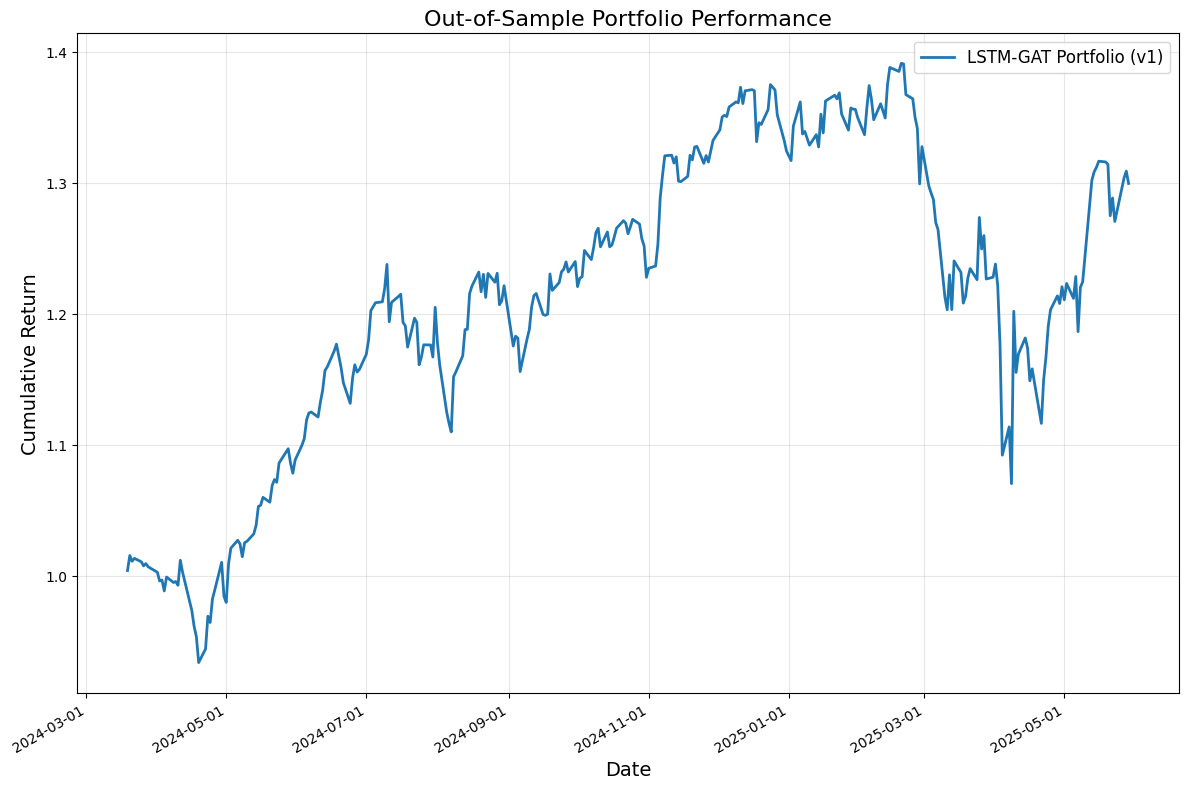

Testing set cumulative return graph finished.


In [ ]:
# Build testing DataFrame
test_price_data = pd.DataFrame({'date': test_dates_list})
for stock in tickers:
    prices = []
    for d in test_dates_list:
        idx = date2idx[d]
        prices.append(all_data[stock].iloc[idx]['close'])
    test_price_data[stock] = prices

# Daily return
returns = test_price_data[tickers].pct_change().dropna().reset_index(drop=True)
weights = weights_df[tickers].iloc[:-1].reset_index(drop=True)

# Portfolio return and equal-weight return
portfolio_returns = (returns.values * weights.values).sum(axis=1)
equal_weights = np.ones(len(tickers)) / len(tickers)
equal_returns = (returns.values * equal_weights).sum(axis=1)

# Cumulative Return
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_equal = (1 + equal_returns).cumprod()

# Visualized
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plot_dates = pd.to_datetime(test_price_data['date'].iloc[1:])

plt.figure(figsize=(12, 8))
plt.plot(plot_dates, cumulative_portfolio, label='LSTM-GAT Portfolio (v1)', linewidth=2)
plt.title('Out-of-Sample Portfolio Performance', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig('Result/V1out_of_sample_performance.png', dpi=300)
plt.show()

print("Testing set cumulative return graph finished.")


In [48]:
# Result DataFrame
result_df = pd.DataFrame({
    'date': plot_dates,
    'lstm_gat_return': portfolio_returns,
    'lstm_gat_cum_return': cumulative_portfolio,
    'equal_weight_return': equal_returns,
    'equal_weight_cum_return': cumulative_equal
})

result_df.to_csv('Result/portfolio_returns_v1.csv', index=False)
print("File path: Result/portfolio_returns_v1.csv")



File path: Result/portfolio_returns_v1.csv


In [ ]:
capm_df = (
    pd.read_csv("Result/capm_cumulative_returns.csv",
                parse_dates=["date"])
      .rename(columns={"cumulative_return": "capm_cumulative"})
)

# If you only want the dates that appear in your LSTM test window:
capm_df = capm_df[capm_df["date"].between(
    test_price_data['date'].iloc[1],
    test_price_data['date'].iloc[-1])]


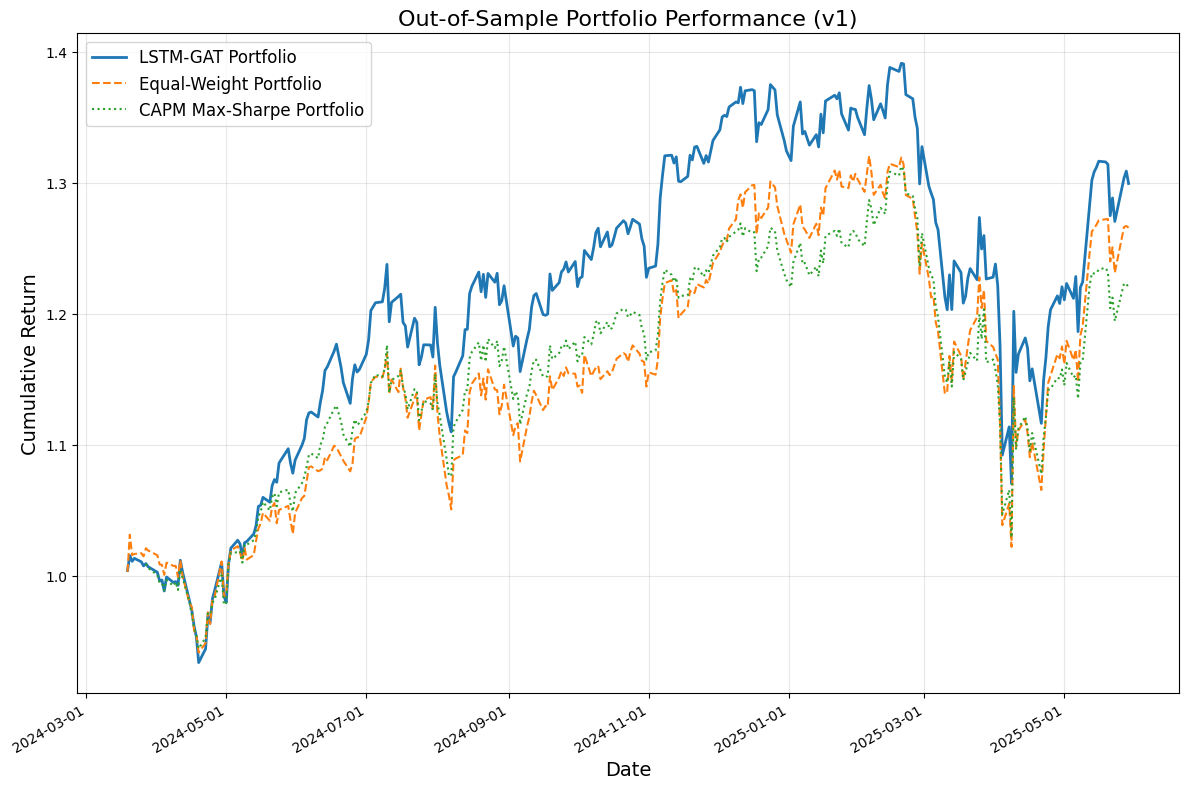

In [ ]:
# Plot LSTM-GAT  vs  Equal-Weight  vs  CAPM Max-Sharpe
plt.figure(figsize=(12, 8))

# already in your code
plt.plot(plot_dates, cumulative_portfolio,
         label='LSTM-GAT Portfolio', linewidth=2)
plt.plot(plot_dates, cumulative_equal,
         label='Equal-Weight Portfolio', linestyle='--')

# NEW:  CAPM curve                               (dotted line)
plt.plot(capm_df['date'], capm_df['capm_cumulative'],
         label='CAPM Max-Sharpe Portfolio', linestyle=':')

plt.title('Out-of-Sample Portfolio Performance (v1)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.savefig('Result/V1_out_of_sample_performance_with_capm.png', dpi=300)
plt.show()


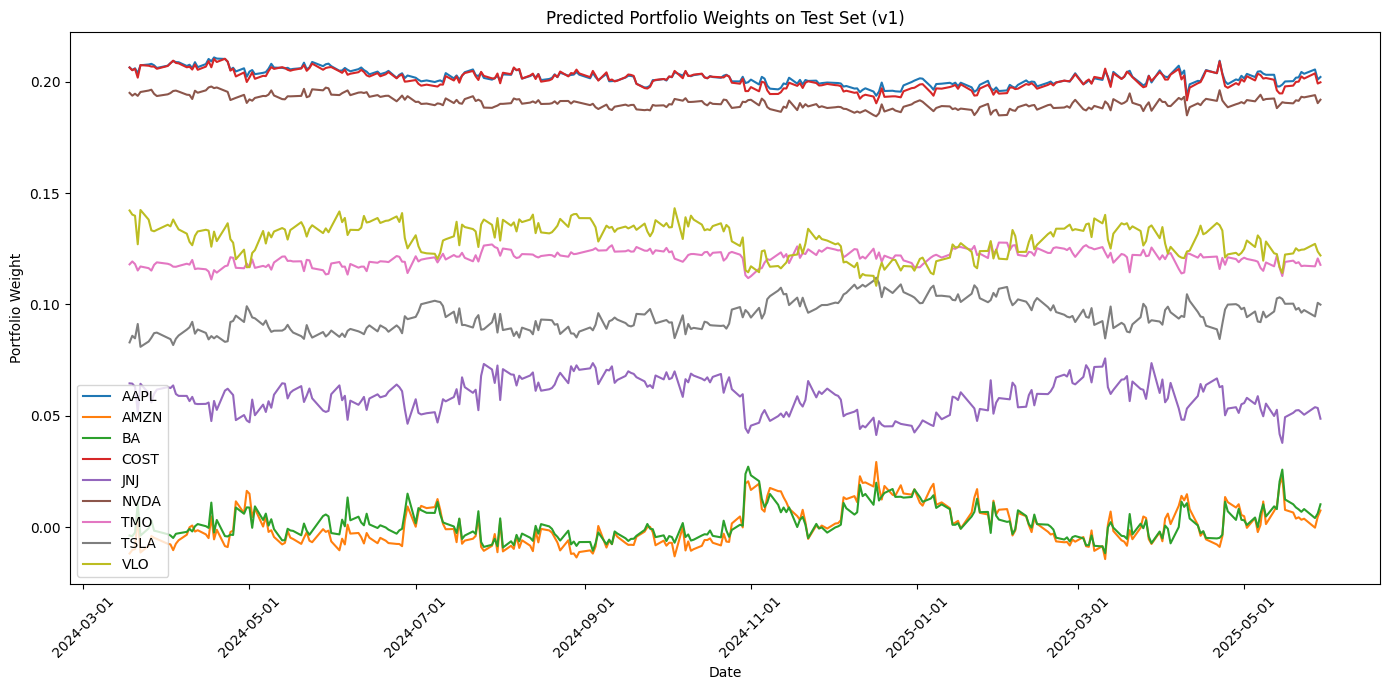

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # For formatting date ticks

plt.figure(figsize=(14, 7))
weights_df['date'] = pd.to_datetime(weights_df['date'])

# Plot portfolio weights
for stock in tickers:
    plt.plot(weights_df['date'], weights_df[stock], label=stock)

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Portfolio Weight')
plt.title('Predicted Portfolio Weights on Test Set (v1)')
plt.legend()

plt.tight_layout()
plt.show()


# CAPM-MVO Result

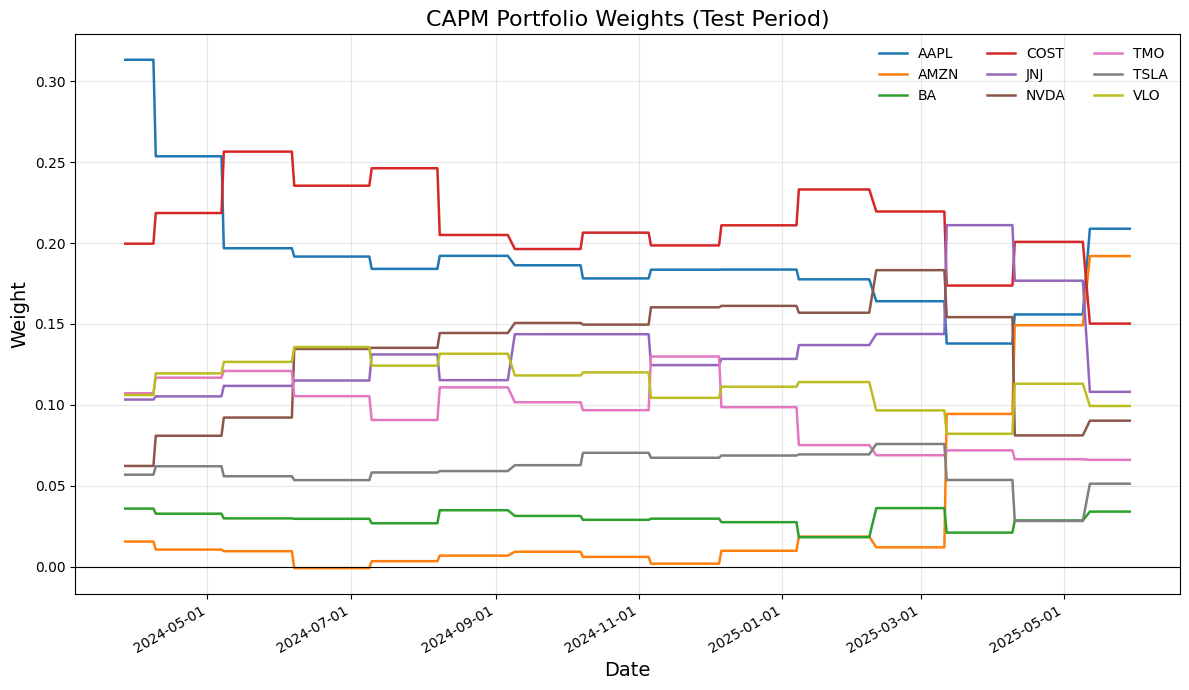

In [52]:
capm_weights_df = (
    pd.read_csv("Result/capm_daily_weights.csv", parse_dates=["date"])
      .sort_values("date")
)


TICKERS = ["AAPL", "AMZN", "BA", "COST", "JNJ", "NVDA", "TMO", "TSLA", "VLO"]


# Plot weights
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 7))

for stk in TICKERS:                      
    plt.plot(capm_weights_df["date"],
             capm_weights_df[stk],
             label=stk, linewidth=1.8)

plt.title("CAPM Portfolio Weights (Test Period)", fontsize=16)
plt.xlabel("Date",  fontsize=14)
plt.ylabel("Weight", fontsize=14)
plt.axhline(0, color="black", linewidth=0.8)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid(alpha=0.3)
plt.legend(ncol=3, fontsize=10, frameon=False)
plt.tight_layout()
plt.savefig("Result/capm_weight_paths.png", dpi=300)
plt.show()


# Evaluation

In [ ]:
import numpy as np
import pandas as pd

def calculate_metrics(returns, var_conf_level=0.95):
    returns = pd.Series(returns)
    cumulative = (1 + returns).cumprod()
    total_return = cumulative.iloc[-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
    max_drawdown = (cumulative / cumulative.cummax() - 1).min()
    
    # Historical Value at Risk (e.g., 5% worst return)
    var_percentile = 100 * (1 - var_conf_level)
    value_at_risk = -np.percentile(returns, var_percentile)

    return total_return, annualized_return, volatility, sharpe_ratio, max_drawdown, value_at_risk

port_metrics = calculate_metrics(portfolio_returns)
equal_metrics = calculate_metrics(equal_returns)
capm_df = pd.read_csv('Result/capm_daily_returns.csv')
capm_returns = capm_df['daily_return'].values[1:]
capm_metrics = calculate_metrics(np.exp(capm_returns) - 1)


In [62]:
print("\n" + "="*80)
print("Out-of-Sample Performance Comparison (Test Period)")
print("="*80)
print(f"{'Metric':<20}{'LSTM-GAT (v1)':>20}{'Equal-Weight':>20}{'CAPM':>20}")
print(f"{'Total Return':<20}{port_metrics[0]:>20.6%}{equal_metrics[0]:>20.6%}{capm_metrics[0]:>20.6%}")
print(f"{'Annualized Return':<20}{port_metrics[1]:>20.6%}{equal_metrics[1]:>20.6%}{capm_metrics[1]:>20.6%}")
print(f"{'Volatility':<20}{port_metrics[2]:>20.6%}{equal_metrics[2]:>20.6%}{capm_metrics[2]:>20.6%}")
print(f"{'Sharpe Ratio':<20}{port_metrics[3]:>20.6f}{equal_metrics[3]:>20.6f}{capm_metrics[3]:>20.6f}")
print(f"{'VaR (95%)':<20}{port_metrics[5]:>20.6%}{equal_metrics[5]:>20.6%}{capm_metrics[5]:>20.6%}")
print(f"{'Max Drawdown':<20}{port_metrics[4]:>20.6%}{equal_metrics[4]:>20.6%}{capm_metrics[4]:>20.6%}")
print("="*80)



Out-of-Sample Performance Comparison (Test Period)
Metric                     LSTM-GAT (v1)        Equal-Weight                CAPM
Total Return                  29.937403%          26.556317%          24.340720%
Annualized Return             24.605357%          21.876063%          20.607402%
Volatility                    25.572940%          24.813493%          22.234806%
Sharpe Ratio                    0.962164            0.881620            0.926808
VaR (95%)                      2.558731%           2.514239%           2.022031%
Max Drawdown                 -23.074754%         -22.604449%         -21.032717%
